In [1]:
# Import Dependencies

%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

In [2]:
# Python SQL toolkit and Object Relational Mapper

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [3]:
# Create an engine for Hawaii Climate/Station Data

engine = create_engine("sqlite:///Resources/hawaii.sqlite") 

In [4]:
# Use inspector to get columns
inspector = inspect(engine)

In [5]:
inspector.get_table_names()

['measurement', 'station']

In [6]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [7]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [8]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
StationData = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [12]:
engine.execute("select * from Measurement limit 10").fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

In [13]:
session.query(func.count(Measurement.date)).all()

[(19550)]

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
## max date
date_max = session.query(func.max(func.strftime("%Y-%m-%d", Measurement.date))).all()
print(date_max[0][0])


2017-08-23


In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
## max date = 2017-08-23. past 12 months >= 2016-08-23
prcp_data = session.query(func.strftime("%Y-%m-%d", Measurement.date), Measurement.prcp).\
filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 23)).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_data, columns= ['date', 'precipitation'])
prcp_df.set_index('date', inplace = True)

# Sort the dataframe by date
prcp_df.sort_values(by='date', ascending=True)


,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


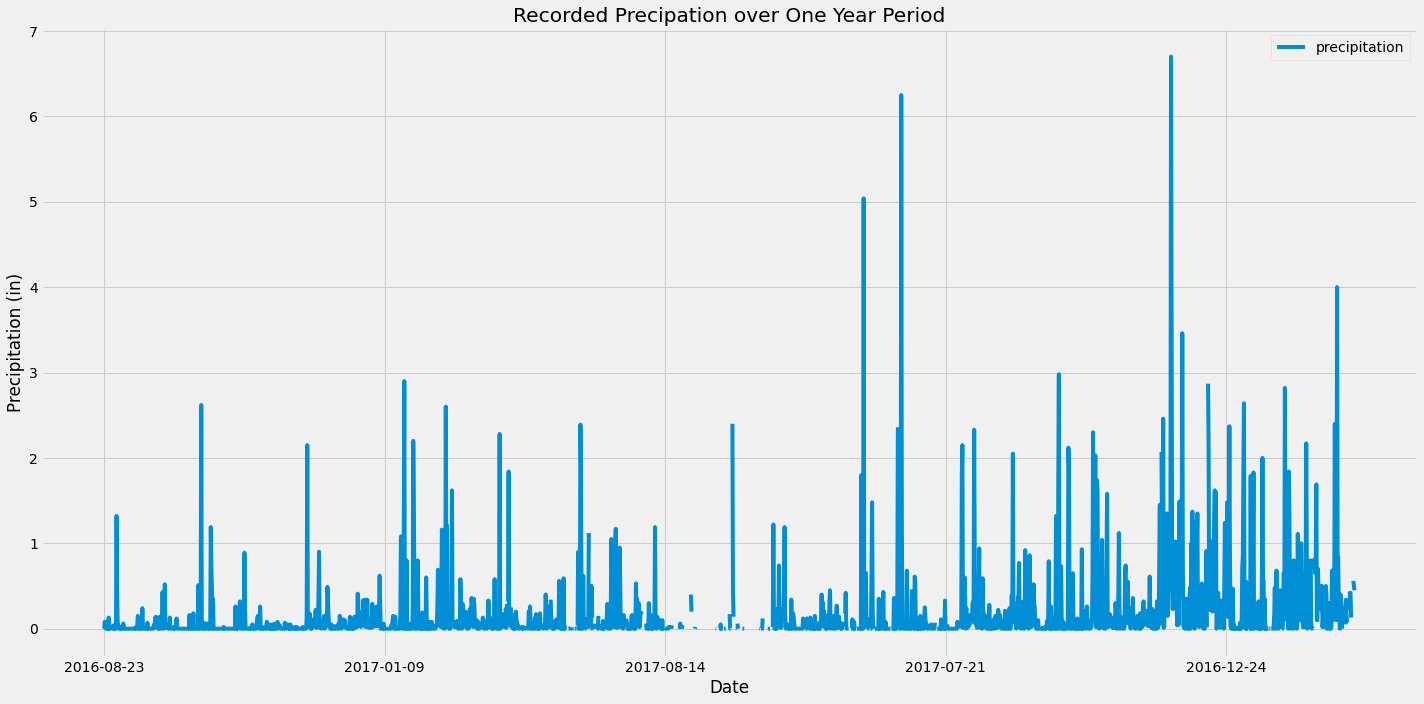

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize = (20,10))
prcp_df.plot(ax=ax, x_compat=True)

ax.set_title("Recorded Precipation over One Year Period")
ax.set_xlabel("Date")
ax.set_ylabel("Precipitation (in)")

plt.tight_layout()
plt.show()

#plt.savefig("OneYearPrecipitation.png")

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [20]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(StationData.id).distinct().count()
station_count

9

In [21]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [27]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
## Most Active Station = 'USC00519281'
obs = session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs),
                   func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
obs


[('USC00519281', 54.0, 85.0, 71.66378066378067)]

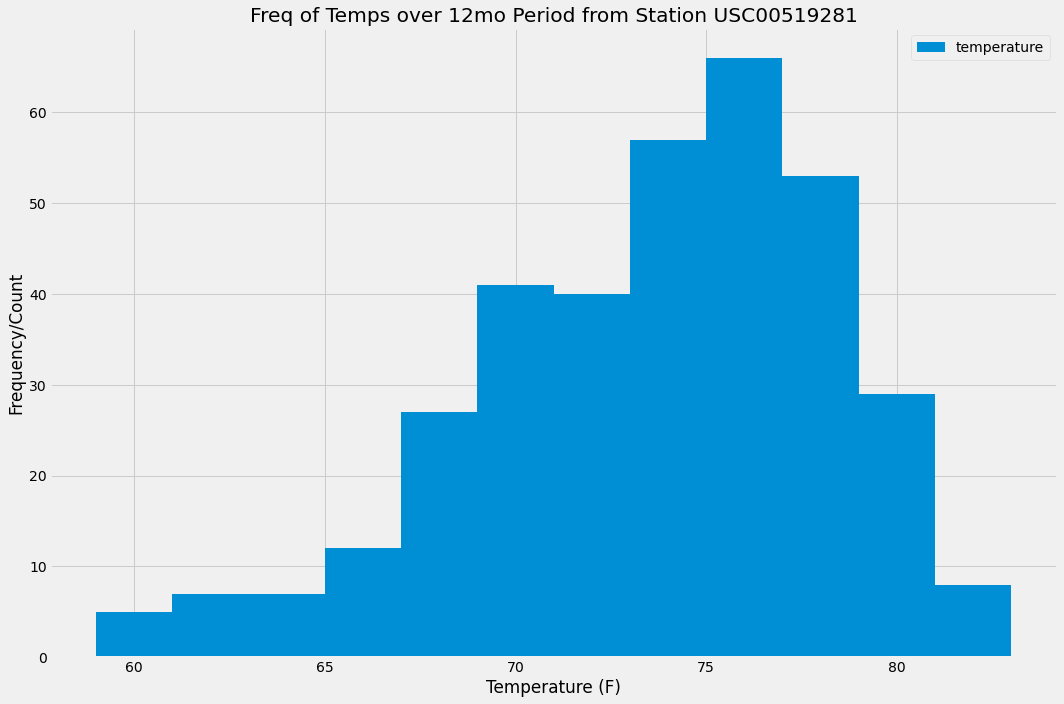

In [35]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
## bins = 12
temps = session.query(Measurement.date, Measurement.tobs).\
filter(Measurement.station=='USC00519281').filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 23)).all()

temps_df = pd.DataFrame(temps, columns=['date','temperature'])

fig, ax = plt.subplots(figsize=(15,10))
temps_df.plot.hist(bins=12, ax=ax)

ax.set_title("Freq of Temps over 12mo Period from Station USC00519281")
ax.set_xlabel("Temperature (F)")
ax.set_ylabel("Frequency/Count")

plt.tight_layout()
plt.show()

#plt.savefig("TempReadings12months.png")